In [1]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt  # viz
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  # векторизация текстов
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF  # dimred
import re
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings("ignore")

data = pd.read_csv("obshhestvo.csv")
data = data.values.tolist() # превращаем в список 
data = [''.join(x) for x in data]
n_samples = len(data)  # размер корпуса
n_features = 1000  # максимальное количество слов в матрице "слово x документ" (= top1000 частотных их всех в корпусе)
n_components = 10  # число тем в корпусе
n_top_words = 20  # порог частотности для визуализаций

In [3]:

stop_words = set(stopwords.words("russian"))
lemmatizer = WordNetLemmatizer()
morph = MorphAnalyzer()

def lemmatize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return res

In [4]:
for i in range(len(data) - 1):  # предобработка текста
    data[i] = data[i].replace(u'\xa0', u' ')
    data[i] = data[i].lower()
    data[i] = re.sub(r'\d+', '', data[i])
    translator = str.maketrans('', '', string.punctuation)
    data[i] = data[i].translate(translator)
    data[i] = " ".join(data[i].split())
    word_tokens = word_tokenize(data[i])
    data[i] = [word for word in word_tokens if word not in stop_words]
    data[i] = ' '.join(data[i])
    data[i] = lemmatize(data[i])
    data[i] = ' '.join(data[i])


print("Количество документов ", len(data))
print(data[0])


Количество документов  329
обычный человек называть слово « выпендриваться » совершенно разный поведение говорить желание покрасить волос розовый цвет например это действительно стоять желание привлечь внимание получить какиеть положительный оценка окружающий получить подтверждение хорошхороший красивый далее точно это желание стоять потребность самовыражение который связать напрямую именно внимание окружающий человек эстетически презентовать также это желание следовать мода человек склонность конформный поведение поведение который ориентировать вести большинство твой значимый референтный группа ты важно выглядеть человек группа подросток например очень часто такой поведение проявляться это казаться парадоксальный вроде краситься непривычный чтоть окружающий мочь расценить выпендреж сам дело наоборот хотеть выделяться значимый группа говорить покупка дорогой вещь связать подтверждение свой статус демонстрация действительно определённый круг обладание дорогой брендовый вещь считаться пр

In [5]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,  # игнорируем слова,которые только в 1 доке или в 95% документов.
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(data)

print(tf.shape)  # матрица "слова x документы"

print(tf_vectorizer.get_feature_names()[996:1000])

(329, 1000)
['язык', 'языковой', 'япония', 'японский']


In [6]:

lda = LatentDirichletAllocation(n_components=n_components, max_iter=20, learning_offset=50)

lda.fit(tf)

print(lda.components_.shape)

(10, 1000)


In [7]:

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15))  # параметры отображения
    axes = axes.flatten()
    all_features = {}  # словарь для сохранения ключевых слов для тем

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь

        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.show()

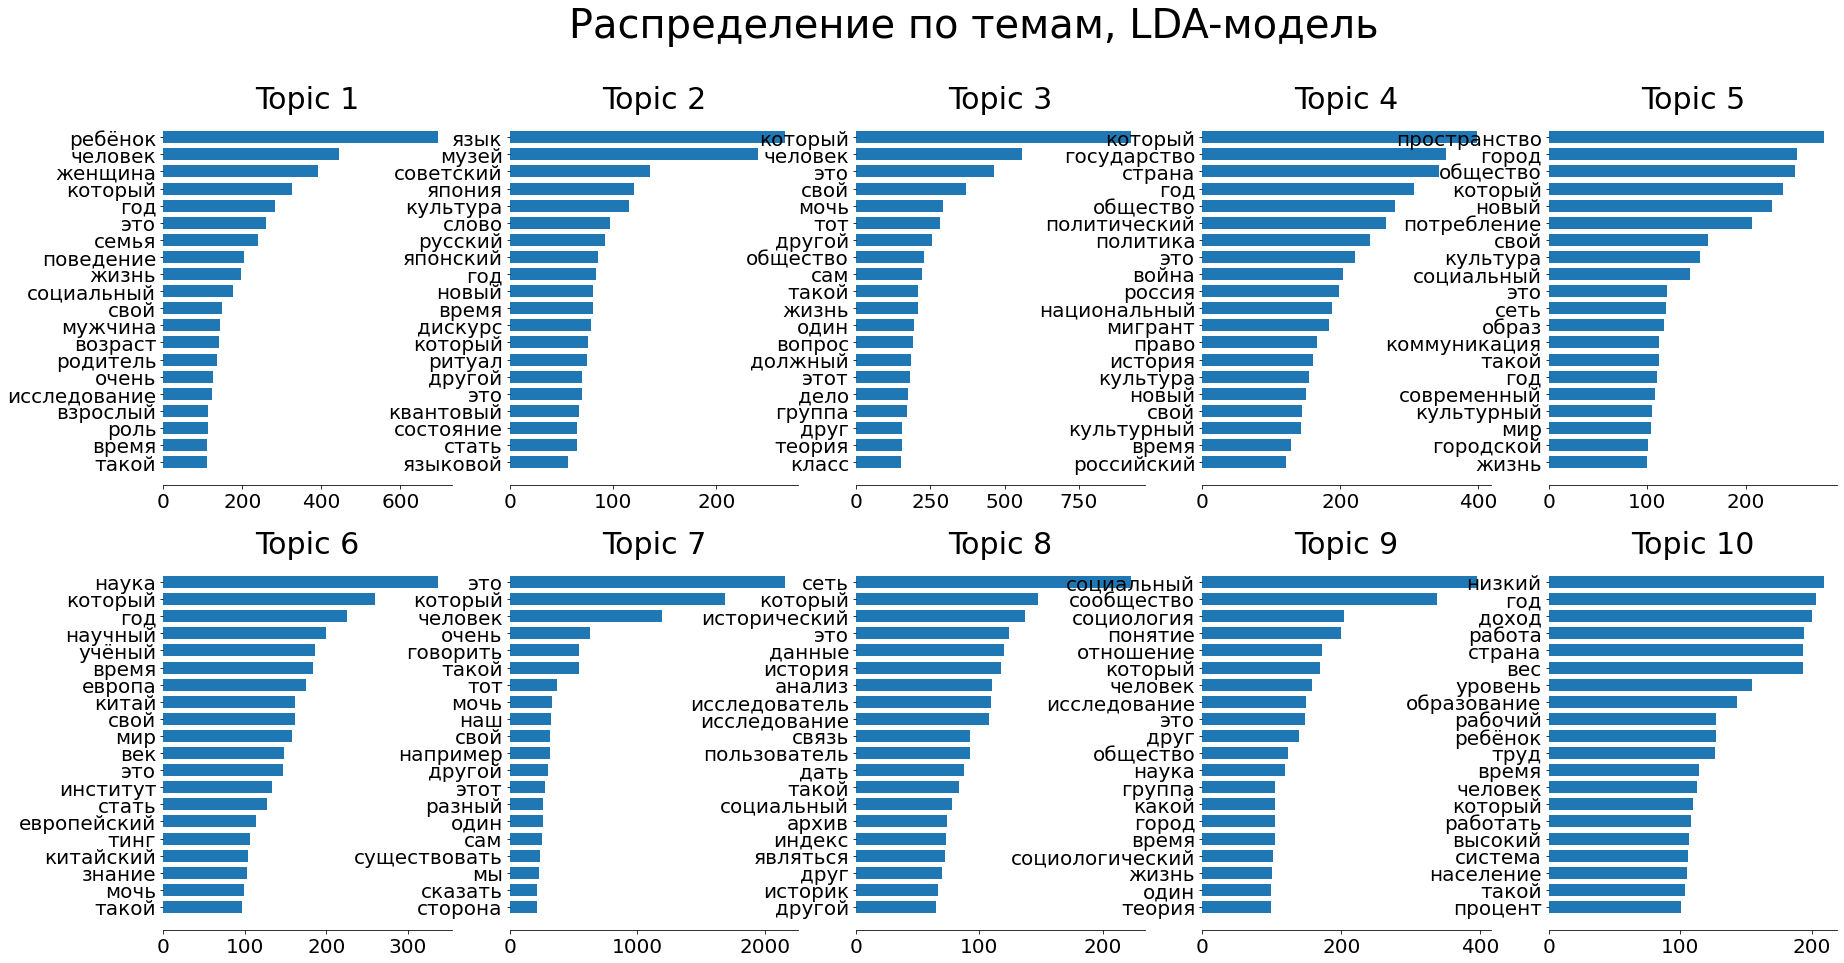

In [8]:

tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lda, tf_feature_names, n_top_words, 'Распределение по темам, LDA-модель')



In [9]:
def print_top_words(model, feature_names, n_top_words):
    all_features = {}

    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
ребёнок человек женщина который год это семья поведение жизнь социальный свой мужчина возраст родитель очень исследование взрослый роль время такой
Topic #1:
язык музей советский япония культура слово русский японский год новый время дискурс который ритуал другой это квантовый состояние стать языковой
Topic #2:
который человек это свой мочь тот другой общество сам такой жизнь один вопрос должный этот дело группа друг теория класс
Topic #3:
который государство страна год общество политический политика это война россия национальный мигрант право история культура новый свой культурный время российский
Topic #4:
пространство город общество который новый потребление свой культура социальный это сеть образ коммуникация такой год современный культурный мир городской жизнь
Topic #5:
наука который год научный учёный время европа китай свой мир век это институт стать европейский тинг китайский знание мочь такой
Topic #6:
это который человек очень говорить такой тот мочь наш свой наприм

In [10]:
doc_topic = lda.transform(tf)

for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax() + 1
    print("doc: {} topic: {}\n".format(n, topic_most_pr))

doc: 0 topic: 7

doc: 1 topic: 9

doc: 2 topic: 9

doc: 3 topic: 9

doc: 4 topic: 7

doc: 5 topic: 9

doc: 6 topic: 3

doc: 7 topic: 6

doc: 8 topic: 1

doc: 9 topic: 1

doc: 10 topic: 7

doc: 11 topic: 9

doc: 12 topic: 1

doc: 13 topic: 7

doc: 14 topic: 7

doc: 15 topic: 4

doc: 16 topic: 3

doc: 17 topic: 7

doc: 18 topic: 8

doc: 19 topic: 9

doc: 20 topic: 5

doc: 21 topic: 1

doc: 22 topic: 3

doc: 23 topic: 4

doc: 24 topic: 4

doc: 25 topic: 2

doc: 26 topic: 9

doc: 27 topic: 1

doc: 28 topic: 9

doc: 29 topic: 3

doc: 30 topic: 3

doc: 31 topic: 9

doc: 32 topic: 4

doc: 33 topic: 7

doc: 34 topic: 1

doc: 35 topic: 7

doc: 36 topic: 1

doc: 37 topic: 7

doc: 38 topic: 6

doc: 39 topic: 3

doc: 40 topic: 3

doc: 41 topic: 9

doc: 42 topic: 4

doc: 43 topic: 3

doc: 44 topic: 10

doc: 45 topic: 1

doc: 46 topic: 1

doc: 47 topic: 3

doc: 48 topic: 7

doc: 49 topic: 10

doc: 50 topic: 7

doc: 51 topic: 5

doc: 52 topic: 3

doc: 53 topic: 1

doc: 54 topic: 9

doc: 55 topic: 1



In [11]:
print(doc_topic)

[[2.92862849e-01 2.49215818e-02 1.17247989e-01 ... 8.13171478e-04
  8.13242237e-04 8.13241984e-04]
 [5.00089518e-03 5.00088597e-03 5.00058005e-03 ... 5.00078467e-03
  9.54990892e-01 5.00016841e-03]
 [3.57288570e-03 3.57181875e-03 3.57222448e-03 ... 3.57207643e-03
  7.54268338e-01 3.57189485e-03]
 ...
 [5.31608311e-02 1.00015854e-03 1.00025995e-03 ... 8.33946038e-02
  2.12502188e-01 1.00018049e-03]
 [4.56758710e-04 4.56715091e-04 1.10416260e-01 ... 4.56779810e-04
  4.56741363e-04 4.56777247e-04]
 [1.79988631e-01 4.87929157e-04 1.74691764e-01 ... 4.87908682e-04
  4.88007844e-04 2.04510906e-01]]


In [12]:
lsa_model = TruncatedSVD(n_components=n_components)

lsa_topic_matrix = lsa_model.fit_transform(tf)

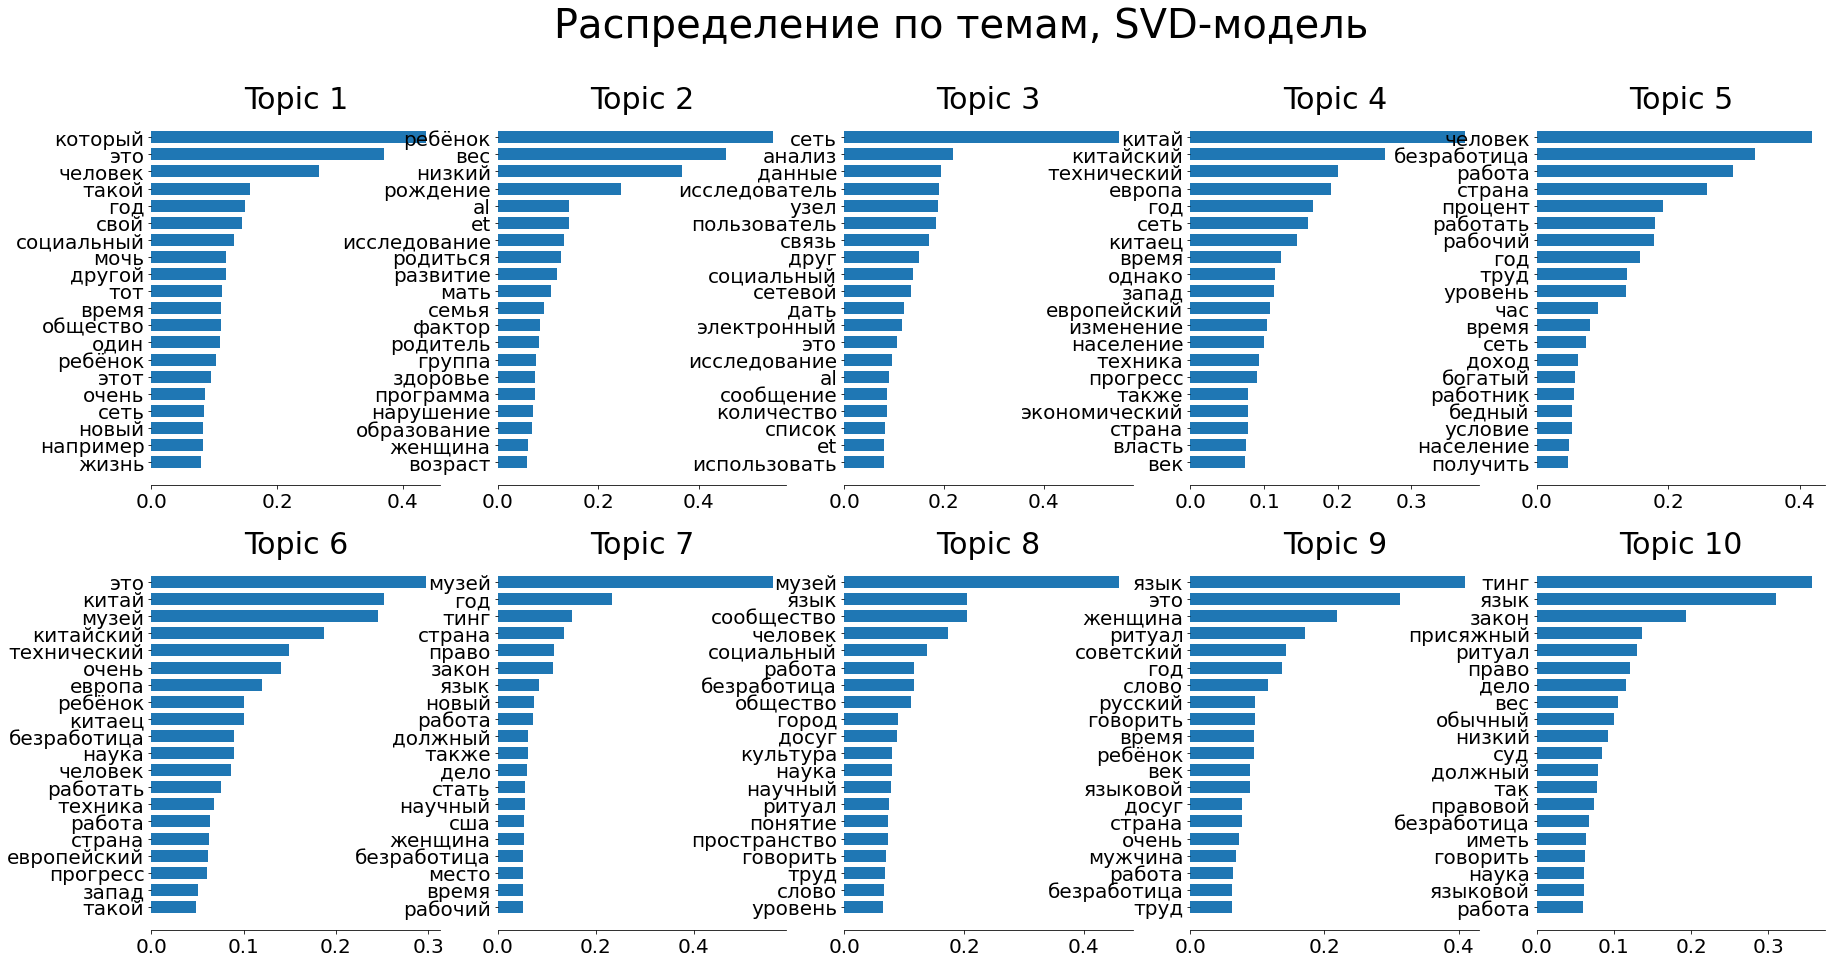

In [13]:
tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lsa_model, tf_feature_names, n_top_words, 'Распределение по темам, SVD-модель')

In [14]:
# для NMF понадобится tf-idf-векторизация, тк tf-idf не бывает негативным

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data)

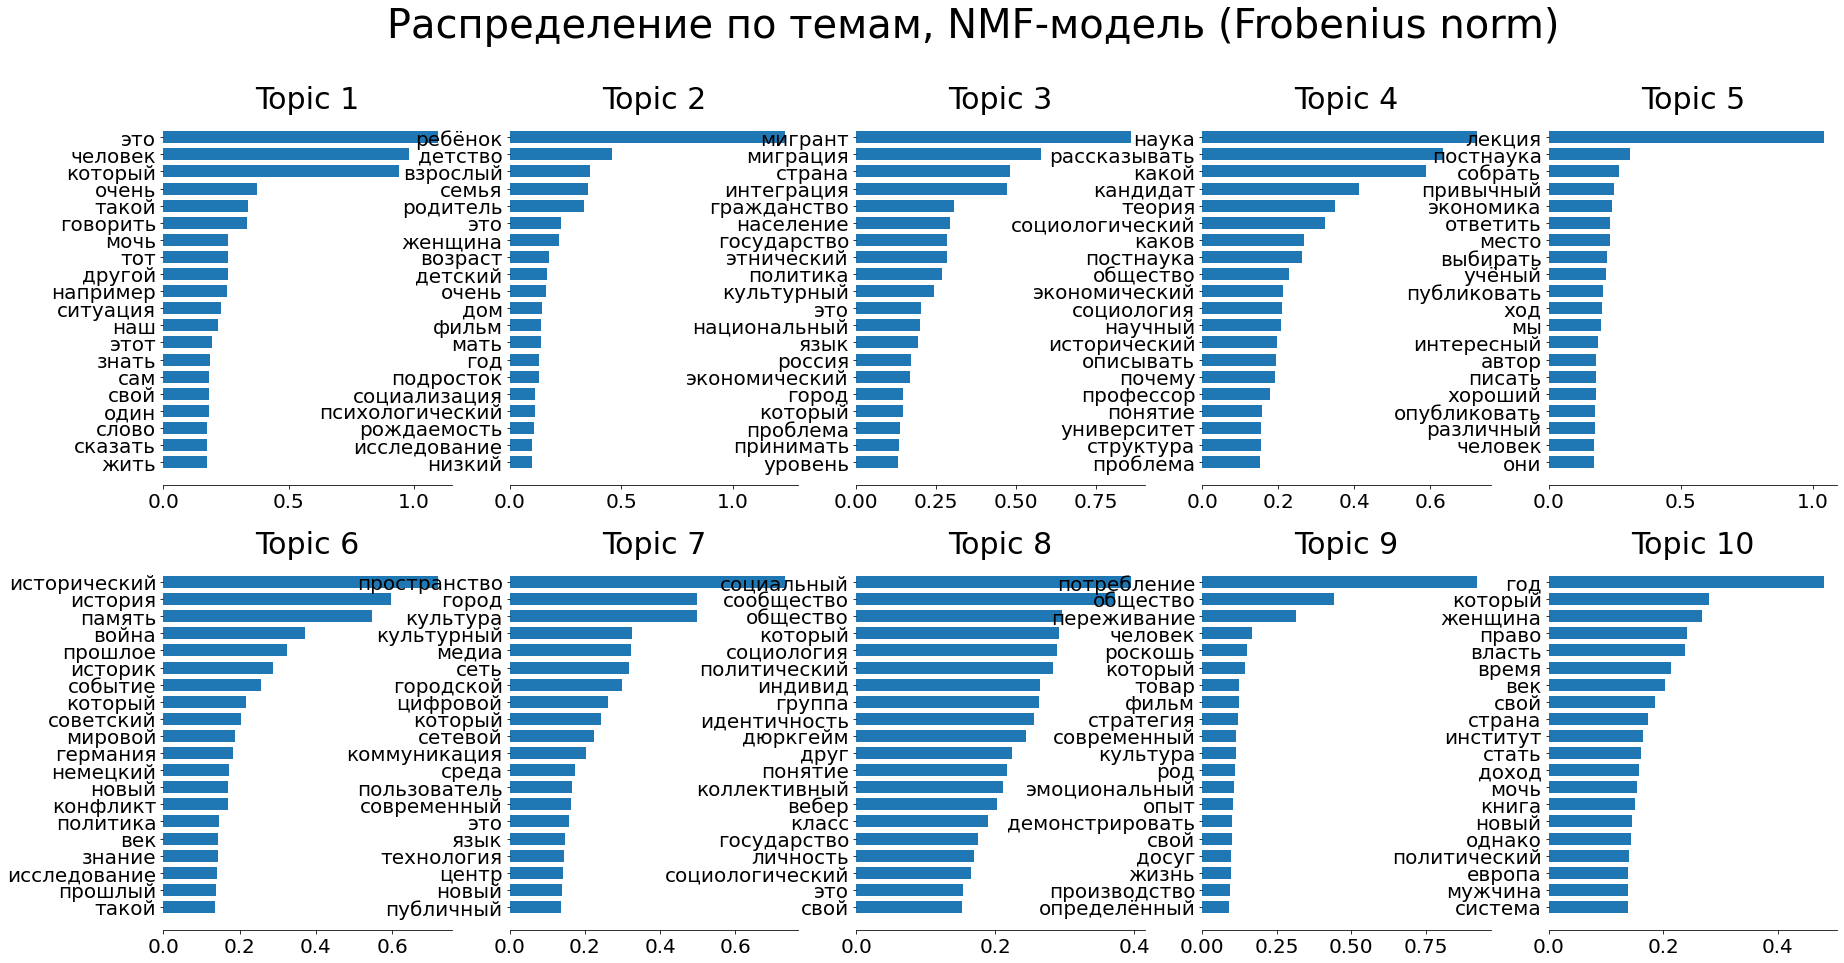

In [15]:
nmf = NMF(n_components=n_components).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель (Frobenius norm)')

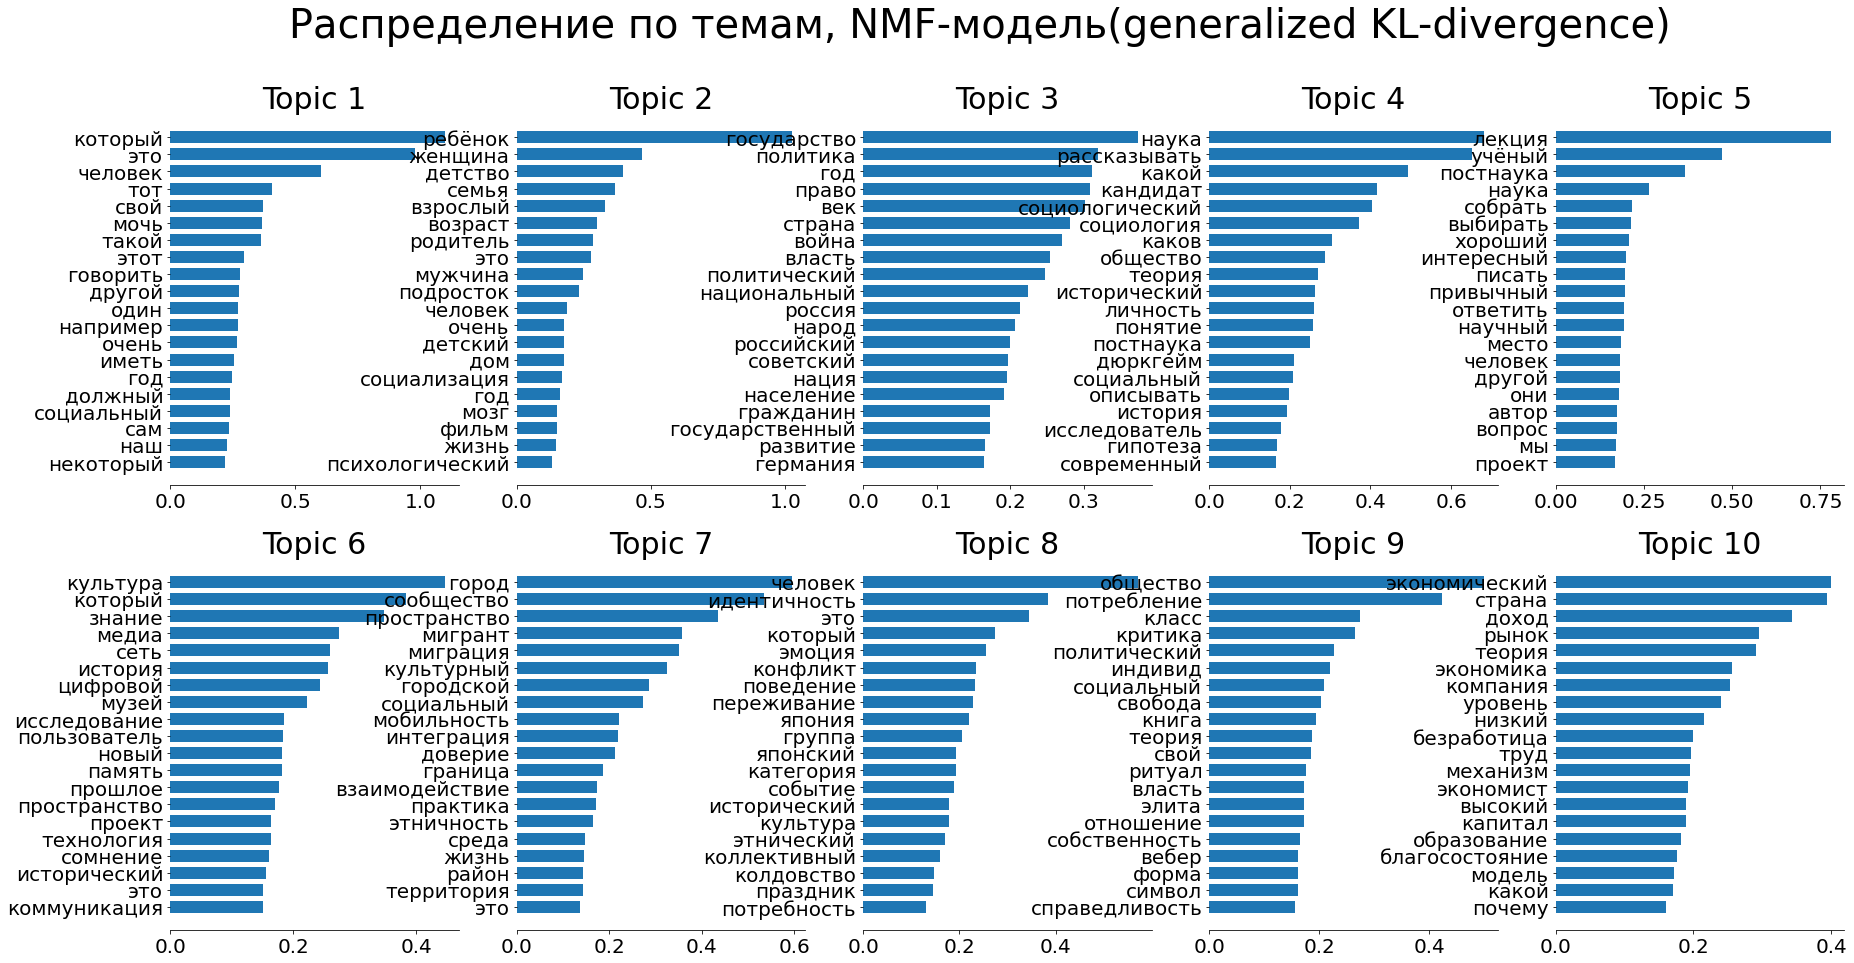

In [16]:
nmf = NMF(n_components=n_components, beta_loss='kullback-leibler', solver='mu').fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель(generalized KL-divergence)')